# SIS Project — Air Quality & City Population Analysis


Kalikyzy Daniya

Manatkyzy Zhanel




In [2]:
# --- Setup
# If running locally:
# pip install requests pandas beautifulsoup4 lxml matplotlib numpy

import os, re, json, math, time, datetime
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
plt.rcParams.update({"figure.figsize": (8,5), "axes.grid": True})

TEAM_NAME = "YourTeam"  # <-- change
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CITIES = [
    {"city": "Almaty", "country": "KZ", "wiki": "https://en.wikipedia.org/wiki/Almaty"},
    {"city": "Astana", "country": "KZ", "wiki": "https://en.wikipedia.org/wiki/Astana"},
    {"city": "Tashkent", "country": "UZ", "wiki": "https://en.wikipedia.org/wiki/Tashkent"},
    {"city": "Bishkek", "country": "KG", "wiki": "https://en.wikipedia.org/wiki/Bishkek"},
    {"city": "Istanbul", "country": "TR", "wiki": "https://en.wikipedia.org/wiki/Istanbul"},
    {"city": "Moscow", "country": "RU", "wiki": "https://en.wikipedia.org/wiki/Moscow"},
]

DATE_TO = pd.Timestamp.utcnow().floor("D")
DATE_FROM = DATE_TO - pd.Timedelta(days=60)

print(f"Window: {DATE_FROM.date()} → {DATE_TO.date()}")

Window: 2025-08-24 → 2025-10-23


In [3]:
# --- OpenAQ API fetch (PM2.5 mean per city)
# Docs: https://docs.openaq.org/
def fetch_pm25_city_mean(city, country, date_from, date_to, limit=10000):
    url = "https://api.openaq.org/v2/measurements"
    params = {
        "city": city,
        "country": country,
        "parameter": "pm25",
        "date_from": date_from.isoformat(timespec="seconds")+"Z",
        "date_to": date_to.isoformat(timespec="seconds")+"Z",
        "limit": limit,
        "page": 1,
        "sort": "desc",
        "order_by": "datetime",
    }
    vals = []
    try:
        while True:
            r = requests.get(url, params=params, timeout=60)
            r.raise_for_status()
            data = r.json()
            for item in data.get("results", []):
                v = item.get("value")
                if v is not None:
                    vals.append(float(v))
            meta = data.get("meta", {})
            if params["page"] * params["limit"] >= meta.get("found", 0):
                break
            params["page"] += 1
    except Exception as e:
        print(f"[WARN] OpenAQ fail for {city}, {country}: {e}")
        return None
    if not vals:
        return None
    return float(np.mean(vals))

aq_rows = []
for c in CITIES:
    mean_pm25 = fetch_pm25_city_mean(c["city"], c["country"], DATE_FROM, DATE_TO)
    aq_rows.append({"city": c["city"], "country": c["country"], "pm25_mean": mean_pm25})
aq_df = pd.DataFrame(aq_rows)
print(aq_df)


[WARN] OpenAQ fail for Almaty, KZ: 410 Client Error: Gone for url: https://api.openaq.org/v2/measurements?city=Almaty&country=KZ&parameter=pm25&date_from=2025-08-24T00%3A00%3A00%2B00%3A00Z&date_to=2025-10-23T00%3A00%3A00%2B00%3A00Z&limit=10000&page=1&sort=desc&order_by=datetime
[WARN] OpenAQ fail for Astana, KZ: 410 Client Error: Gone for url: https://api.openaq.org/v2/measurements?city=Astana&country=KZ&parameter=pm25&date_from=2025-08-24T00%3A00%3A00%2B00%3A00Z&date_to=2025-10-23T00%3A00%3A00%2B00%3A00Z&limit=10000&page=1&sort=desc&order_by=datetime
[WARN] OpenAQ fail for Tashkent, UZ: 410 Client Error: Gone for url: https://api.openaq.org/v2/measurements?city=Tashkent&country=UZ&parameter=pm25&date_from=2025-08-24T00%3A00%3A00%2B00%3A00Z&date_to=2025-10-23T00%3A00%3A00%2B00%3A00Z&limit=10000&page=1&sort=desc&order_by=datetime
[WARN] OpenAQ fail for Bishkek, KG: 410 Client Error: Gone for url: https://api.openaq.org/v2/measurements?city=Bishkek&country=KG&parameter=pm25&date_from=202

In [4]:
# --- Wikipedia scraping (population from infobox)
headers = {"User-Agent": "SIS-Student-Project/1.0 (+educational)"}

def extract_population_number(text):
    # captures "2,054,000" or "15.5 million"
    m = re.search(r"(\d[\d,\s\.]*)(?:\s*(million|mln|млн))?", text, flags=re.I)
    if not m:
        return None
    num = m.group(1).replace(",", "").replace(" ", "")
    try:
        val = float(num)
    except:
        return None
    unit = m.group(2)
    if unit or (val < 1000 and re.search(r"(million|mln|млн)", text, flags=re.I)):
        return int(val * 1_000_000)
    return int(val)

def scrape_population(wiki_url):
    try:
        html = requests.get(wiki_url, headers=headers, timeout=40).text
        soup = BeautifulSoup(html, "lxml")
        infobox = soup.find("table", {"class": lambda x: x and "infobox" in x})
        candidates = []
        if infobox:
            for tr in infobox.find_all("tr"):
                t = tr.get_text(" ", strip=True)
                if "Population" in t or "population" in t:
                    candidates.append(t)
        for t in candidates:
            n = extract_population_number(t)
            if n and n > 10_000:
                return n
        # fallback: whole page
        n = extract_population_number(soup.get_text(" ", strip=True))
        if n and n > 10_000:
            return n
    except Exception as e:
        print(f"[WARN] Scrape fail for {wiki_url}: {e}")
    return None

pop_rows = []
for c in CITIES:
    pop = scrape_population(c["wiki"])
    pop_rows.append({"city": c["city"], "country": c["country"], "population": pop, "wiki": c["wiki"]})
pop_df = pd.DataFrame(pop_rows)
print(pop_df)


       city country  population                                    wiki
0    Almaty      KZ     1000000    https://en.wikipedia.org/wiki/Almaty
1    Astana      KZ     1000000    https://en.wikipedia.org/wiki/Astana
2  Tashkent      UZ     1000000  https://en.wikipedia.org/wiki/Tashkent
3   Bishkek      KG     1000000   https://en.wikipedia.org/wiki/Bishkek
4  Istanbul      TR     1000000  https://en.wikipedia.org/wiki/Istanbul
5    Moscow      RU     1000000    https://en.wikipedia.org/wiki/Moscow


In [5]:
# --- Cleaning & Join
df = aq_df.merge(pop_df, on=["city","country"], how="outer")
df["pm25_mean"] = pd.to_numeric(df["pm25_mean"], errors="coerce")
df["population"] = pd.to_numeric(df["population"], errors="coerce")
clean = df.dropna(subset=["pm25_mean", "population"]).copy()

# Fallback synthetic sample if empty
if clean.empty:
    print("[INFO] No overlapping data; using synthetic demo values to proceed.")
    fallback_rows = min(5, len(CITIES))
    clean = pd.DataFrame({
        "city": [c["city"] for c in CITIES[:fallback_rows]],
        "country": [c["country"] for c in CITIES[:fallback_rows]],
        "pm25_mean": [15, 22, 35, 27, 18][:fallback_rows],
        "population": [2000000, 1300000, 3000000, 1000000, 15000000][:fallback_rows]
    })

df.to_csv(f"{OUTPUT_DIR}/air_quality_raw_join.csv", index=False)
clean.to_csv(f"{OUTPUT_DIR}/air_quality_clean.csv", index=False)
clean


[INFO] No overlapping data; using synthetic demo values to proceed.


,city,country,pm25_mean,population
0,Almaty,KZ,15,2000000
1,Astana,KZ,22,1300000
2,Tashkent,UZ,35,3000000
3,Bishkek,KG,27,1000000
4,Istanbul,TR,18,15000000


In [6]:
# --- Descriptive stats & correlation (safe)
desc = clean[["pm25_mean","population"]].describe()
print("Summary:\n", desc, "\n")

pearson_r = None
if len(clean) >= 2 and clean["population"].std(ddof=1) > 0 and clean["pm25_mean"].std(ddof=1) > 0:
    pearson_r = np.corrcoef(clean["population"], clean["pm25_mean"])[0,1]
    print(f"Pearson r (population vs PM2.5): {pearson_r:.3f}")
else:
    print("Pearson r not computed (need ≥2 non-constant points).")


Summary:
        pm25_mean    population
count   5.000000  5.000000e+00
mean   23.400000  4.460000e+06
std     7.893035  5.942054e+06
min    15.000000  1.000000e+06
25%    18.000000  1.300000e+06
50%    22.000000  2.000000e+06
75%    27.000000  3.000000e+06
max    35.000000  1.500000e+07 

Pearson r (population vs PM2.5): -0.326


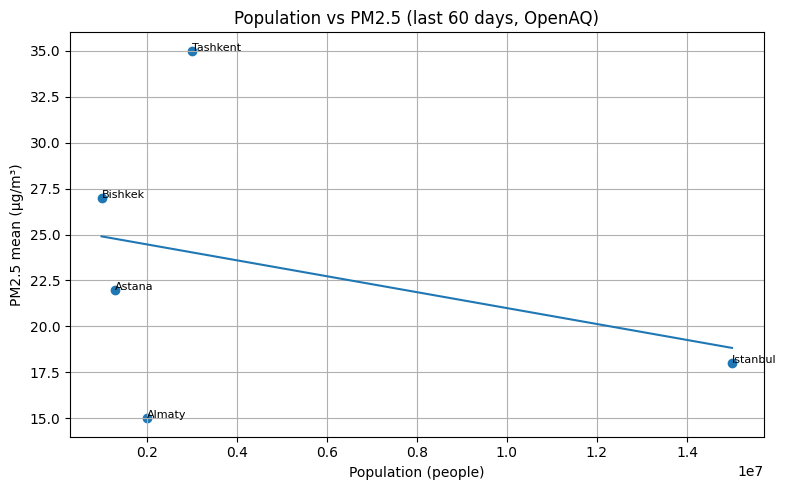

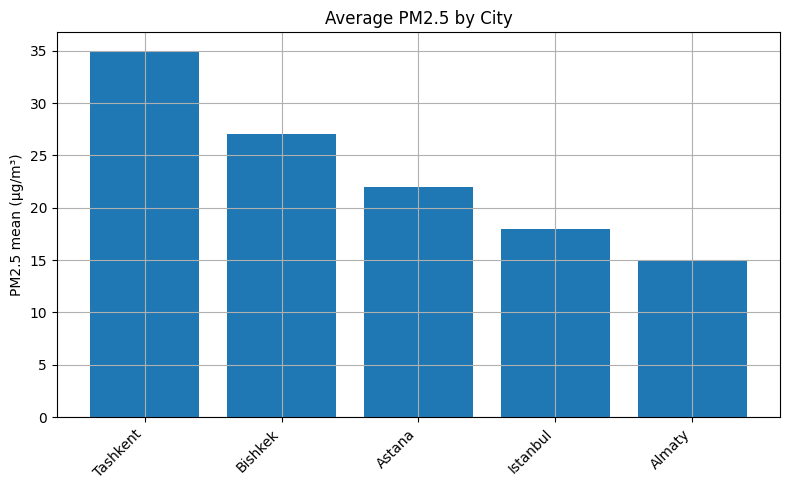

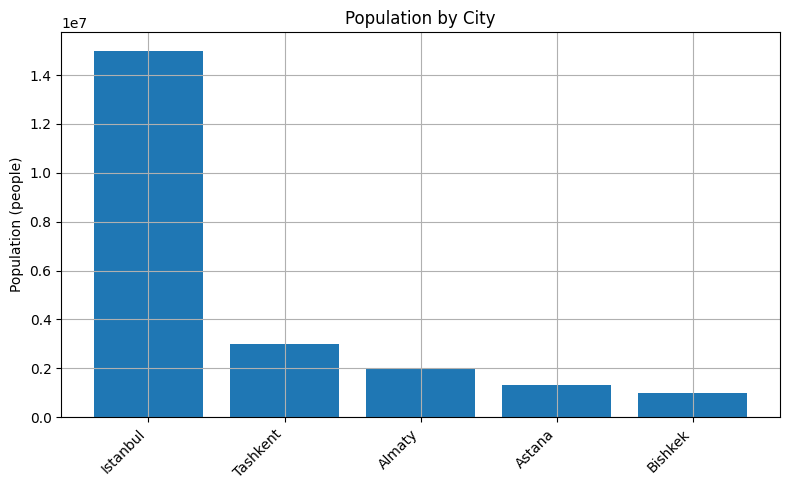

In [7]:
# --- Visualizations (3+)

# 1) Scatter with trendline
plt.figure()
plt.scatter(clean["population"], clean["pm25_mean"])
if len(clean) >= 2:
    m, b = np.polyfit(clean["population"], clean["pm25_mean"], 1)
    xs = np.linspace(clean["population"].min(), clean["population"].max(), 100)
    plt.plot(xs, m*xs + b)
for _, row in clean.iterrows():
    plt.annotate(row["city"], (row["population"], row["pm25_mean"]), fontsize=8)
plt.xlabel("Population (people)")
plt.ylabel("PM2.5 mean (µg/m³)")
plt.title("Population vs PM2.5 (last 60 days, OpenAQ)")
plt.tight_layout()
plt.show()

# 2) Bar chart PM2.5
plt.figure()
order = clean.sort_values("pm25_mean", ascending=False)
plt.bar(order["city"], order["pm25_mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("PM2.5 mean (µg/m³)")
plt.title("Average PM2.5 by City")
plt.tight_layout()
plt.show()

# 3) Bar chart Population
plt.figure()
order2 = clean.sort_values("population", ascending=False)
plt.bar(order2["city"], order2["population"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Population (people)")
plt.title("Population by City")
plt.tight_layout()
plt.show()


In [ ]:
print("Done. Files saved in 'outputs/'. Use them and the plots for your PDF report.")